<a href="https://colab.research.google.com/github/ShailJoshi/dockerconnect/blob/main/Recommendation_System_MLOps_Project_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install modelstore
!pip install boto3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 14.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from keras import backend as K
from pprint import pprint

import requests
import zipfile
import io

from modelstore import ModelStore
import json

In [ ]:

keras.__version__

'2.8.0'

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

r = requests.get(DATASET_LINK)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
u_info = pd.read_csv('ml-100k/u.info', header=None)
print(u_info)

u_data_str = 'user id | movie id | rating | timestamp'
u_data_headers = u_data_str.split(' | ')

u_data_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=u_data_headers)
print(u_data_dataset.head())

len(u_data_dataset), max(u_data_dataset['movie id']),max(u_data_dataset['movie id'])

u_item_str = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
u_item_headers = u_item_str.split(' | ')
print(u_item_headers)

items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=u_item_headers,encoding='latin-1')
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

combined_dataset = pd.merge(u_data_dataset, movie_dataset, how='inner', on='movie id')

master_dataset = combined_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})
master_dataset

                0
0       943 users
1      1682 items
2  100000 ratings
   user id  movie id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0
...,...,...,...
99688,943,"Wizard of Oz, The (1939)",3.0
99689,943,Wolf (1994),2.0
99690,943,Wyatt Earp (1994),1.0
99691,943,Young Guns (1988),4.0


In [ ]:
user_encoder = LabelEncoder()
master_dataset['user'] = user_encoder.fit_transform(master_dataset['user id'].values)
n_users = master_dataset['user'].nunique()

movie_encoder = LabelEncoder()
master_dataset['movie'] = movie_encoder.fit_transform(master_dataset['movie title'].values)
n_movies = master_dataset['movie'].nunique()

master_dataset['rating'] = master_dataset['rating'].values.astype(np.float32)
min_rating = min(master_dataset['rating'])
max_rating = max(master_dataset['rating'])
n_users, n_movies, min_rating, max_rating

master_dataset.head()


X = master_dataset[['user', 'movie']].values
y = master_dataset['rating'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

n_factors = 150

x_train_mat = [x_train[:, 0], x_train[:, 1]]
x_test_mat = [x_test[:, 0], x_test[:, 1]]

x_train, x_train_mat, x_train_mat[0].shape

# Normalizing labels

y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

# Building a Softmax Deep Neural Network

## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of users
u = keras.layers.embeddings.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

#Input layers for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.embeddings.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

# Adding a Dense layer to the architecture
# Activation ReLu
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Activation ReLu
x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

#Softmax Activation
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# model.compile(optimizer='sgd', loss=root_mean_squared_error, metrics=['accuracy'])

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 150)       141450      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       249600      ['input_2[0][0]']                
                                                                                              

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)
data = model.fit(x = x_train_mat, y = y_train, batch_size=128, epochs=2, verbose=1, validation_data=(x_test_mat, y_test) ,shuffle=True,callbacks=[reduce_lr])

Epoch 1/2
701/701 [==============================] - 4s 5ms/step - loss: 0.8017 - accuracy: 0.0605 - val_loss: 0.5253 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/2
701/701 [==============================] - 3s 4ms/step - loss: 0.5311 - accuracy: 0.0609 - val_loss: 0.5143 - val_accuracy: 0.0617 - lr: 0.0100


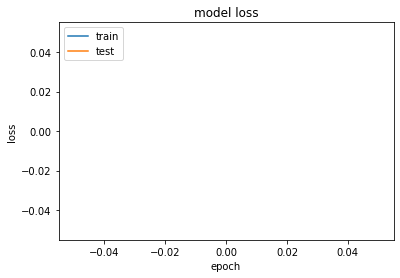

In [ ]:
plt.plot(data.history["loss"][5:])
plt.plot(data.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
# from tensorflow.keras.models import Sequential, save_model, load_model

# export_path = 'movie_model/1/'
# tf.saved_model.save(model, os.path.join('/content/',export_path))

model.save('movie_model.h5')

In [ ]:
os.environ['aws_access_key_id'] = "X"
os.environ['aws_access_key_id'] = "X"

model_store = ModelStore.from_aws_s3("iiscdvc")




TypeError: ignored

In [ ]:
domain = "prod-movie-model"
meta_data = model_store.upload(domain, model=model)

print(json.dumps(meta_data, indent=4))

In [ ]:
print ("Model generation is done. It is saved as well. Now, consume it elsewhere.")

Model generation is done. It is saved as well. Now, consume it elsewhere.


In [ ]:
# from google.colab import files
# download_path = '/content/movie_model.zip'
# !zip -r {download_path} {export_path}

# New Code to consume model and make movie prediction/recommendation for a given user

In [ ]:
print ("A new code.. This will use trained model and make prediction")

A new code.. This will use trained model and make prediction


In [ ]:
# download_path = '/content/movie_model.zip'
# files.download(download_path)

In [ ]:
def recommender_system(user_id, model, n_movies):

  encoded_user_id = user_encoder.transform([user_id])

  seen_movies = list(master_dataset[master_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(master_dataset['movie']), max(master_dataset['movie'])+1) if i not in seen_movies]
  
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = movie_encoder.inverse_transform(sorted_index)
  
  
  print("Top", n_movies, "Movie recommendations for the User ", user_id, "are: ")
  pprint(list(recommended_movies[:n_movies]))


In [ ]:
user_id= int(input("Enter user id: "))
n_movies = int(input("Enter number of movies to be recommended: "))
recommender_system(user_id,model,n_movies)

Enter user id: 1
Enter number of movies to be recommended: 5
Top 5 Movie recommendations for the User  1 are: 
['Blown Away (1994)',
 'Simple Twist of Fate, A (1994)',
 'Babysitter, The (1995)',
 'Hear My Song (1991)',
 'Leaving Las Vegas (1995)']
